# node2vec
---
[node2vec](http://snap.stanford.edu/node2vec/) for link prediction:
1. Perform train-test split
1. Train skip-gram model on random walks within training graph
2. Get node embeddings from skip-gram model
3. Create bootstrapped edge embeddings by taking the Hadamard product of node embeddings
4. Train a logistic regression classifier on these edge embeddings (possible edge --> edge score between 0-1)
5. Evaluate these edge embeddings on the validation and test edge sets

node2vec source code: https://github.com/aditya-grover/node2vec

Dataset: Continous radoslaw
Number of nodes: 167
Number of edges: 3251
Number of time frames: 9

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import pickle
import random
import csv

Step 1: Load in the networks, make the training and test edge lists

In [2]:
MasterGraph = nx.read_edgelist("radoslaw-email/radoslaw.csv", nodetype=int, delimiter=",")
for edge in MasterGraph.edges():
    MasterGraph[edge[0]][edge[1]]['weight'] = 1

print MasterGraph.number_of_nodes()
print MasterGraph.number_of_edges()

with open("radoslaw-email/radoslaw_m18_weighted.csv", 'rb') as f:
    weighted_edges_18 = [[int(x) for x in rec] for rec in csv.reader(f, delimiter=',')]
    weighted_edges_18 = map(tuple, weighted_edges_18)

G18 = nx.MultiGraph()
G18.add_weighted_edges_from(weighted_edges_18)


G9 = nx.read_edgelist("radoslaw-email/radoslaw_m9.csv", nodetype = int, delimiter = ",")
for edge in G9.edges():
    G9[edge[0]][edge[1]]['weight'] = 1

    
    
## All the nodes are in MasterNodes    
MasterNodes = MasterGraph.nodes()

167
3251


In [3]:
### Training - Test split  
'''''
first add all the nodes that are in MasterGraph but not in 
G9
'''''
for i in MasterNodes:
    if i not in G9.nodes():
        G9.add_node(i)
        
adj_sparse = nx.to_scipy_sparse_matrix(G9)

In [4]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks

adj_sparse = nx.to_scipy_sparse_matrix(G9)

adj_train_del_del, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.0, prevent_disconnect = True)


In [5]:
# Inspect train/test split
print "Total nodes:", adj_sparse.shape[0]
print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print "Training edges (positive):", len(train_edges)
print "Training edges (negative):", len(train_edges_false)
print "Validation edges (positive):", len(val_edges)
print "Validation edges (negative):", len(val_edges_false)
print "Test edges (positive):", len(test_edges)
print "Test edges (negative):", len(test_edges_false)

Total nodes: 167
Total edges: 1133
Training edges (positive): 794
Training edges (negative): 794
Validation edges (positive): 0
Validation edges (negative): 0
Test edges (positive): 339
Test edges (negative): 339


The positive training edges are in the edgelist "train_edges".

The negative training edges are in the edgelist "train_edges_false".

The positive test edges are in the edgelist "test_edges".

The negative test edges are in the edgelist "test_edges_false".

Step 2: add all the nodes in G1, G2, G3 that are not present

In [6]:
'''
add all the nodes that are in the MasterGraph but not in 
G1, G2 and G3, G8
'''
for i in MasterNodes:
    if i not in G18.nodes():
        G18.add_node(i)

In [7]:
print "Edges before removal: "
print "G18:  ", G18.number_of_edges()


'''
for every snapshot, delete all the edges that occur in the 
test set, this is important because the training of node2vec
can only be done on the training network and not on edges that
are used for testing
'''
for i in range(0,len(test_edges)):
        if G18.has_edge(test_edges[i, 0], test_edges[i, 1]):
            G18.remove_edges_from([(test_edges[i, 0], test_edges[i, 1])]*len(G18[test_edges[i, 0]][test_edges[i, 1]]))
            
print "Edges after removal: "
print "G18:  ", G18.number_of_edges()

Edges before removal: 
G18:   72221
Edges after removal: 
G18:   66175


## 3. Train node2vec (Learn Node Embeddings)

In [8]:
import node2vecWeight_bidirectional as node2vec
from gensim.models import Word2Vec

C:\Users\Tim_Dell_XPS\AppData\Local\Continuum\anaconda2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [10]:
# Preprocessing, generate walks
G18_n2v = node2vec.Graph(G18, DIRECTED, P, Q)
G18_n2v.preprocess_transition_probs()

walksG18 = G18_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)

walksG18 = [map(str, walk) for walk in walksG18]

# Train skip-gram model
modelG18 = Word2Vec(walksG18, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)


# Store embeddings mapping
emb_mappingsG18 = modelG18.wv

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


## 4. Create Edge Embeddings

In [11]:
#G17 = nx.Graph(G17)

In [12]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_listG18 = []

for node_index in range(1, adj_sparse.shape[0]+1):
    node_str = str(node_index)
    
    node_embG18 = emb_mappingsG18[node_str]
    emb_listG18.append(node_embG18)
    
emb_matrixG18 = np.vstack(emb_listG18)

In [13]:
def get_edge_embeddings_static(edge_list):
    embs_s = []
    for edge in edge_list:
        
        node1 = edge[0]
        node2 = edge[1]
        
        embG18_1 = emb_matrixG18[node1]
        embG18_2 = emb_matrixG18[node2]
        
        edge_embG18 = np.multiply(embG18_1, embG18_2)
        embs_s.append(edge_embG18)
        
    embs_s = np.array(embs_s)
    
    return embs_s

In [14]:
## STATIC
# Train-set edge embeddings
pos_train_edge_embs_s = get_edge_embeddings_static(train_edges)
neg_train_edge_embs_s = get_edge_embeddings_static(train_edges_false)
train_edge_embs_s = np.concatenate([pos_train_edge_embs_s, neg_train_edge_embs_s])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs_s = get_edge_embeddings_static(val_edges)
neg_val_edge_embs_s = get_edge_embeddings_static(val_edges_false)
val_edge_embs_s = np.concatenate([pos_val_edge_embs_s, neg_val_edge_embs_s])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs_s = get_edge_embeddings_static(test_edges)
neg_test_edge_embs_s = get_edge_embeddings_static(test_edges_false)
test_edge_embs_s = np.concatenate([pos_test_edge_embs_s, neg_test_edge_embs_s])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

## 5. Evaluate Edge Embeddings

First, the basic topological classifiers are calculated for the test and training set.

In [15]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


edge_classifier_lr_stat = LogisticRegression(random_state=0)
edge_classifier_lr_stat.fit(train_edge_embs_s, train_edge_labels)


edge_classifier_RF_stat = RandomForestClassifier(n_estimators = 50)
edge_classifier_RF_stat.fit(train_edge_embs_s, train_edge_labels)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
##  Gradient Boosted Regression Trees
from sklearn.ensemble import GradientBoostingClassifier
edge_classifier_gb_stat = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, max_depth=8, random_state=0).fit(train_edge_embs_s, train_edge_labels)


In [17]:
# Predicted edge scores: probability of being of class "1" (real edge)
# val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
# val_roc = roc_auc_score(val_edge_labels, val_preds)
# val_ap = average_precision_score(val_edge_labels, val_preds)

In [18]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds_lr_s = edge_classifier_lr_stat.predict_proba(test_edge_embs_s)[:, 1]
test_roc_lr_s = roc_auc_score(test_edge_labels, test_preds_lr_s)
test_ap_lr_s = average_precision_score(test_edge_labels, test_preds_lr_s)


test_preds_rf_s = edge_classifier_RF_stat.predict_proba(test_edge_embs_s)[:, 1]
test_roc_rf_s = roc_auc_score(test_edge_labels, test_preds_rf_s)
test_ap_rf_s = average_precision_score(test_edge_labels, test_preds_rf_s)


test_preds_gb_s = edge_classifier_gb_stat.predict_proba(test_edge_embs_s)[:, 1]
test_roc_gb_s = roc_auc_score(test_edge_labels, test_preds_gb_s)
test_ap_gb_s = average_precision_score(test_edge_labels, test_preds_gb_s)


In [19]:
# print 'node2vec Validation ROC score: ', str(val_roc)
# print 'node2vec Validation AP score: ', str(val_ap)
print 'node2vec Test ROC score logistic regression continous: ', str(test_roc_lr_s)
print 'node2vec Test ROC score random forest continous: ', str(test_roc_rf_s)
print 'node2vec Test ROC score gradient boosting continous: ', str(test_roc_gb_s)
print 'node2vec Test AP score logistic regression continous: ', str(test_ap_lr_s)
print 'node2vec Test AP score random forest continous: ', str(test_ap_rf_s)
print 'node2vec Test AP score gradient boosting continous: ', str(test_ap_gb_s)



node2vec Test ROC score logistic regression continous:  0.7268123319497741
node2vec Test ROC score random forest continous:  0.8400422899209021
node2vec Test ROC score gradient boosting continous:  0.8582069421602666
node2vec Test AP score logistic regression continous:  0.6839368857915901
node2vec Test AP score random forest continous:  0.8086619905463643
node2vec Test AP score gradient boosting continous:  0.8273933538523208


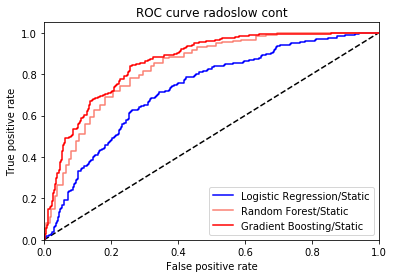

In [20]:
## ROC curve
fpr_lr_s, tpr_lr_s, _ = roc_curve(test_edge_labels, test_preds_lr_s)
fpr_rf_s, tpr_rf_s, _ = roc_curve(test_edge_labels, test_preds_rf_s)
fpr_gb_s, tpr_gb_s, _ = roc_curve(test_edge_labels, test_preds_gb_s)


fig_roc = plt.figure()

plt.plot([0,1], [0, 1], 'k--')
plt.step(fpr_lr_s, tpr_lr_s, color = "b", alpha = 1, where = 'post', label = "Logistic Regression/Static")
plt.step(fpr_rf_s, tpr_rf_s, color = "salmon", alpha = 1, where = 'post', label = "Random Forest/Static")
plt.step(fpr_gb_s, tpr_gb_s, color = "red", alpha = 1, where = 'post', label = "Gradient Boosting/Static")



plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve radoslow cont')

plt.legend()

fig_roc.savefig("ROC_Radoslaw_cont.png")

